<a href="https://colab.research.google.com/github/bhatnira/Acetylcholinesterase-Inhibitor-Discovery/blob/main/classificationModeling_GraphAttentionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Graph Attention Transformer Classification Modeling


## Introduction
Graph Attention Network incorporates masked self-attentional layers within its structure, adeptly managing graph-structured inputs and surmounting the constraints identified in earlier models (Veličković et al., 2018)


## Data loading and Preprocessing



In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.0/954.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 21.2 MB/s eta 0:00:00


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.7.2.dev'

In [ ]:
import deepchem as dc
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Primary Dataset

In [ ]:
import pandas as pd
df=pd.read_excel("/content/drive/MyDrive/Predictive Generative transfer learning/Part_2_standarizationOfMolecule/StandarizedSmiles_cutOFF800daltonMolecularweight.xlsx")

In [ ]:
df.head(5)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,tSNE1,tSNE2,MolecularWeight,Frequency,cleanedMol
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,-52.761700,-42.736099,275.352,27,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,-63.027809,-53.765778,325.364,1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.0,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,-61.968063,-54.078575,263.293,1,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,57.758297,-8.911607,212.296,4,Cc1ccc2c(N)c3c(nc2c1)CCCC3
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,61.242554,5.783804,341.455,3,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2


In [ ]:
# Count the frequency of each label
label_counts = df['classLabel'].value_counts()
# Print the frequency of labels
print(label_counts)

0    2330
1    1747
Name: classLabel, dtype: int64


In [ ]:
df.shape

(4077, 15)

In [ ]:
df.shape

(4077, 15)

In [ ]:
!pip install --pre deepchem

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install dgl transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 19.5 MB/s eta 0:00:00


In [ ]:
import deepchem as dc
from deepchem.models.torch_models import GATModel
import matplotlib.pyplot as plt

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## Conv Mol Featurization

In [ ]:
import deepchem as dc
import pandas as pd
from rdkit import Chem
from deepchem.feat import ConvMolFeaturizer

# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df['classLabel'].tolist()

# Create a DeepChem dataset from the features and targets
dataset = dc.data.NumpyDataset(features, targets)

# Split the dataset into training, validation, and test sets
splitter = dc.splits.RandomSplitter()
import deepchem as dc
splitter = dc.splits.RandomSplitter()
train_frac = 0.7  # 80% of the data for training
valid_frac = 0.15  # 10% of the data for validation
test_frac = 0.15   # 10% of the data for testing

# Use the splitter to split the dataset
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset, frac_train=train_frac, frac_valid=valid_frac, frac_test=test_frac
)


In [ ]:
train_smiles = train_dataset.ids
val_smiles = valid_dataset.ids

In [ ]:
train_smiles

array([3680, 2149, 369, ..., 3964, 2094, 1292], dtype=object)

In [ ]:
!pip install dgllife

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install dgl

In [ ]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print CUDA version
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("CUDA is not available on this system.")


CUDA Version: 12.1


In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


## Graph Attention Transformer Modeling with hyperparameter optimization

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
import deepchem as dc

# Define a function to create and train the GATModel
def create_and_train_gat_model(train_dataset, n_heads, hidden_feats, dropout, learning_rate, nb_epoch):
    model = GATModel(n_tasks=1, mode='classification', device='cpu', n_heads=n_heads,
                     hidden_feats=hidden_feats, dropout=dropout, learning_rate=learning_rate)
    model.fit(train_dataset, nb_epoch=nb_epoch)
    return model

# Define your hyperparameter search space
param_dist = {
    'n_heads': [4, 8],
    'hidden_feats': [64, 128],
    'dropout': [0.3, 0.5],
    'learning_rate': [0.001, 0.01],
    'nb_epoch': [10, 30, 60]
}

# Define the evaluation metric you want to use (e.g., ROC-AUC, accuracy, etc.)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

# Define your model_builder function
def model_builder(**model_params):
    n_heads = model_params['n_heads']
    hidden_feats = model_params['hidden_feats']
    dropout = model_params['dropout']
    learning_rate = model_params['learning_rate']
    nb_epoch = model_params['nb_epoch']

    return create_and_train_gat_model(train_dataset, n_heads, hidden_feats, dropout, learning_rate, nb_epoch)

# Create an optimizer and perform hyperparameter search
optimizer = dc.hyper.GridHyperparamOpt(model_builder)
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(param_dist, train_dataset, test_dataset, metric)

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparams)


Best Hyperparameters: {'n_heads': 8, 'hidden_feats': 128, 'dropout': 0.3, 'learning_rate': 0.01, 'nb_epoch': 60}
CPU times: user 1h 31min 39s, sys: 17.7 s, total: 1h 31min 57s
Wall time: 1h 32min 42s


## Evaluaton of best model

In [ ]:
import deepchem as dc

# Define the roc_auc_score metric
roc_auc_metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

# Evaluate the model on the training dataset
train_scores = best_model.evaluate(train_dataset, [roc_auc_metric])

# Print available keys in the train_scores dictionary
print("Available keys in train_scores:", train_scores.keys())

# Access the ROC AUC score using the correct key
roc_auc_train_score = train_scores[roc_auc_metric.name]

print('Training set ROC AUC score:', roc_auc_train_score)

# Evaluate the model on the test dataset
test_scores = best_model.evaluate(test_dataset, [roc_auc_metric])

# Print available keys in the test_scores dictionary
print("Available keys in test_scores:", test_scores.keys())

# Access the ROC AUC score using the correct key
roc_auc_test_score = test_scores[roc_auc_metric.name]
print('Test set ROC AUC score:', roc_auc_test_score)

Available keys in train_scores: dict_keys(['roc_auc_score'])
Training set ROC AUC score: 0.8517752931688282
Available keys in test_scores: dict_keys(['roc_auc_score'])
Test set ROC AUC score: 0.82469073687204


Epoch 1/50, Train Accuracy: 0.6593, Valid Accuracy: 0.6536, Test Accuracy: 0.6552
Epoch 2/50, Train Accuracy: 0.6225, Valid Accuracy: 0.6373, Test Accuracy: 0.6127
Epoch 3/50, Train Accuracy: 0.5990, Valid Accuracy: 0.5866, Test Accuracy: 0.5980
Epoch 4/50, Train Accuracy: 0.6923, Valid Accuracy: 0.6716, Test Accuracy: 0.6944
Epoch 5/50, Train Accuracy: 0.6446, Valid Accuracy: 0.6487, Test Accuracy: 0.6422
Epoch 6/50, Train Accuracy: 0.7024, Valid Accuracy: 0.6797, Test Accuracy: 0.7157
Epoch 7/50, Train Accuracy: 0.7035, Valid Accuracy: 0.7092, Test Accuracy: 0.7271
Epoch 8/50, Train Accuracy: 0.6789, Valid Accuracy: 0.6748, Test Accuracy: 0.6585
Epoch 9/50, Train Accuracy: 0.7389, Valid Accuracy: 0.7288, Test Accuracy: 0.7320
Epoch 10/50, Train Accuracy: 0.7252, Valid Accuracy: 0.7386, Test Accuracy: 0.7320
Epoch 11/50, Train Accuracy: 0.7143, Valid Accuracy: 0.6928, Test Accuracy: 0.7141
Epoch 12/50, Train Accuracy: 0.7466, Valid Accuracy: 0.7598, Test Accuracy: 0.7516
Epoch 13/50, 

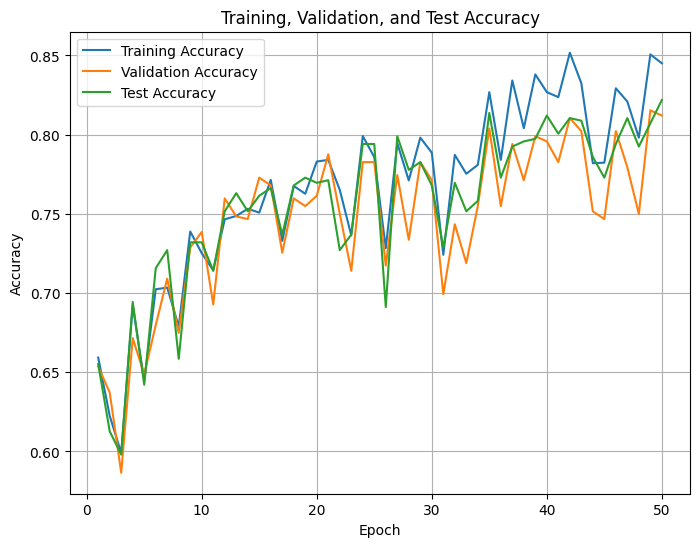

In [ ]:
import deepchem as dc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

train_accuracies = []
valid_accuracies = []
test_accuracies = []
num_epochs = 50

for epoch in range(num_epochs):
    # Fit the model for one epoch
    model.fit(train_dataset, nb_epoch=1)

    # Calculate training accuracy
    train_scores = best_model.evaluate(train_dataset, [dc.metrics.Metric(dc.metrics.accuracy_score)])
    train_accuracy = train_scores["accuracy_score"]

    # Calculate validation accuracy
    valid_scores = best_model.evaluate(valid_dataset, [dc.metrics.Metric(dc.metrics.accuracy_score)])
    valid_accuracy = valid_scores["accuracy_score"]

    # Calculate test accuracy
    test_scores = best_model.evaluate(test_dataset, [dc.metrics.Metric(dc.metrics.accuracy_score)])
    test_accuracy = test_scores["accuracy_score"]

    # Append the accuracy values to the lists
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    test_accuracies.append(test_accuracy)

    # Print the accuracies for the current epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training, validation, and test accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), valid_accuracies, label="Validation Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Make predictions on the test dataset
y_true_valid = valid_dataset.y.ravel()  # Flatten y_true to a 1D array
y_pred_valid = best_model.predict(valid_dataset).reshape(-1, 2)  # Reshape y_pred to (num_samples, num_classes)
y_pred_binary_valid = np.argmax(y_pred_valid, axis=1)  # Convert probabilities to binary predictions


valid_accuracy = accuracy_score(y_true_valid, y_pred_binary_valid)
valid_accuracy

0.7140522875816994

In [ ]:
import deepchem as dc

# Define the roc_auc_score metric
roc_auc_metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

matthew_coff= dc.metrics.Metric(dc.metrics.matthews_corrcoef)
matthew_coff=best_model.evaluate(test_dataset, [matthew_coff])
# Evaluate the model on the training dataset
kappa_score= dc.metrics.Metric(dc.metrics.kappa_score)
kappa_score=best_model.evaluate(test_dataset, [kappa_score])
train_scores = best_model.evaluate(train_dataset, [roc_auc_metric])
precision_score= dc.metrics.Metric(dc.metrics.precision_score)
# Print available keys in the train_scores dictionary
print("Available keys in train_scores:", train_scores.keys())

# Access the ROC AUC score using the correct key
roc_auc_train_score = train_scores[roc_auc_metric.name]

print('Training set ROC AUC score:', roc_auc_train_score)

# Evaluate the model on the test dataset
test_scores = best_model.evaluate(test_dataset, [roc_auc_metric])

# Print available keys in the test_scores dictionary
print("Available keys in test_scores:", test_scores.keys())

# Access the ROC AUC score using the correct key
roc_auc_test_score = test_scores[roc_auc_metric.name]

print('Test set ROC AUC score:', roc_auc_test_score)

print ('The mathew coefficient is:',matthew_coff)

print('The kappa score is:',kappa_score )
print('Precision score is:',precision_score )


Available keys in train_scores: dict_keys(['roc_auc_score'])
Training set ROC AUC score: 0.8517752931688282
Available keys in test_scores: dict_keys(['roc_auc_score'])
Test set ROC AUC score: 0.82469073687204
The mathew coefficient is: {'matthews_corrcoef': 0.0}
The kappa score is: {'cohen_kappa_score': 0.0}
Precision score is: <deepchem.metrics.metric.Metric object at 0x7db8be71db10>


## Cross species evaluation

### Upload and prep for species datasets
Species datasets: eel (CHEMBL4078), cow (CHEMBL4768), mouse (CHEMBL3199), ray (CHEMBL4780), mosquito (CHEMBL2046266), mouse (CHEMBL3198), and independent  human dataset containing molecules not present on  ChEMBL22  were obtained from Vignaux et al(2023) for validation and specificity inferences.

In [ ]:
df_humanIndependent=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_humanIndependent.xlsx')
df_eel=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_eel.xlsx')
df_mouse=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')
df_cow=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_cow.xlsx')
df_ray=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_ray.xlsx')
df_mosquito=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')

In [ ]:
df_humanIndependent

,CdId,Structure,Mol Weight,Formula,index,PMID,Chemical Name,Smiles,Standard Value,Standard Units,Standard Relation,Unnamed: 6,Unnamed: 7,InChi,MW,standardized_Standard Units,neg_log_M_Standard Valuemean,binary_activities,cleanedMol
0,1,NaN,400.950,C23H29ClN2O2,0,PMID31316368,1-(4-Amino-5-chloro-2-methoxyphenyl)-3-(1-(3-m...,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,161,nM,'=',NaN,NaN,MLGZODWUOIZOPO-UHFFFAOYSA-N,400.191756,nm,7.132772,1,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1
1,2,NaN,582.793,C35H46N6O2,1,PMID32932702,13-bis[5-(o-cyanobenzylethylamino)pentyl]-6-me...,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,7.3,nM,'=',NaN,NaN,HSTIQTQFKBPUBM-UHFFFAOYSA-N,582.368225,nm,8.453114,1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...
2,3,NaN,610.847,C37H50N6O2,2,PMID32932702,13-bis[6-(o-cyanobenzylethylamino)hexyl]-6-met...,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,29,nM,'=',NaN,NaN,VZLMPEWEWNBPNU-UHFFFAOYSA-N,610.399525,nm,7.578695,1,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...
3,4,NaN,618.826,C38H46N6O2,3,PMID32932702,13-bis[5-(o-cyanobenzylethylamino)pentyl]-quin...,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,38,nM,'=',NaN,NaN,MUHGJDAKOZGKRH-UHFFFAOYSA-N,618.368225,nm,7.378729,1,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...
4,5,NaN,213.303,C14H17N2,4,PMID29534488,9-Amino-1234-tetrahydro-10-methylacridin-10-iu...,C[n+]1c2c(c(N)c3ccccc31)CCCC2,12,µM,'=',NaN,NaN,XZCXCNCLCXZILU-UHFFFAOYSA-O,213.138625,um,4.920819,0,C[n+]1c2c(c(N)c3ccccc31)CCCC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,204,NaN,427.504,C26H25N3O3,211,PMID31852270,N-(4-((Benzyl(methyl)amino)methyl)phenyl)-7-me...,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,2.3,µM,'=',NaN,NaN,RISZPUMPOOHFSR-UHFFFAOYSA-N,427.189592,um,5.638272,0,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...
204,205,NaN,457.530,C27H27N3O4,212,PMID31852270,N-(4-((benzyl(methyl)amino)methyl)phenyl)-67-d...,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,4.5,µM,'=',NaN,NaN,PHAZELHZUUHUTB-UHFFFAOYSA-N,457.200156,um,5.346787,0,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...
205,206,NaN,554.739,C33H42N6O2,213,PMID32932702,13-bis[4-(o-cyanobenzylethylamino)butyl]-6-met...,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,7,nM,'=',fixed,NaN,HWHRMPMHFDVNAP-UHFFFAOYSA-N,554.336925,nm,8.154902,1,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...
206,207,NaN,526.685,C31H38N6O2,214,PMID32932702,13-bis[5-(o-cyanobenzylamino)pentyl]-6-methylu...,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,480,nM,'=',NaN,NaN,LCCSXIJDKYAOER-UHFFFAOYSA-N,526.305624,nm,6.318759,1,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...


In [ ]:
df_eel

,SMILES,single-class-label,cleanedMol
0,c1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc...,1,c1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc...
1,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,1,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
2,Cc1cccc(Nc2ccccc2C(=O)NCCCCCC(=O)NCCCCNc2c3c(n...,1,Cc1cccc(Nc2ccccc2C(=O)NCCCCCC(=O)NCCCCNc2c3c(n...
3,O=C1Nc2ccccc2/C1=C\c1cc[n+](Cc2ccccc2Cl)cc1,1,O=C1Nc2ccccc2/C1=C\c1cc[n+](Cc2ccccc2Cl)cc1
4,COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2,0,COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2
...,...,...,...
5454,O=[N+]([O-])c1ccc2nc(-c3ccccc3)cc(-c3ccccc3)c2c1,0,O=[N+]([O-])c1ccc2nc(-c3ccccc3)cc(-c3ccccc3)c2c1
5455,Clc1ccc2nc(-c3c[nH]c4ccccc34)cc(-c3ccccc3)c2c1,0,Clc1ccc2nc(-c3c[nH]c4ccccc34)cc(-c3ccccc3)c2c1
5456,COc1ccc(-c2cc(-c3ccccc3)c3cc([N+](=O)[O-])ccc3...,0,COc1ccc(-c2cc(-c3ccccc3)c3cc([N+](=O)[O-])ccc3...
5457,C#CCN(C)[C@@H](C)Cc1ccccc1,0,C#CCN(C)[C@@H](C)Cc1ccccc1


### Featurization of smiles on species datasets - Graph Attention Transformer

In [ ]:
df_humanIndependent.to_csv('inhibitor_HumanIndependent.csv', index=False)
df_eel.to_csv('inhibitor_eel.csv', index=False)
df_mouse.to_csv('inhibitor_mouse.csv', index=False)
df_cow.to_csv('inhibitor_cow.csv', index=False)
df_ray.to_csv('inhibitor_ray.csv', index=False)
df_mosquito.to_csv('inhibitor_mosquito.csv', index=False)

### human

In [ ]:
# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_humanIndependent['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_humanIndependent['binary_activities'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_humanIndependent= dc.data.NumpyDataset(features, targets)

### eel

In [ ]:

# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_eel['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_eel['single-class-label'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_eel= dc.data.NumpyDataset(features, targets)

### cow

In [ ]:
# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_cow['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_cow['single-class-label'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_cow= dc.data.NumpyDataset(features, targets)


### mosquito

In [ ]:
# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_mosquito['cleanedMol'].tolist())
# Extract the target values from the DataFrame
targets = df_mosquito['single-class-label'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_mosquito= dc.data.NumpyDataset(features, targets)

### ray

In [ ]:
# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_ray['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_ray['single-class-label'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_ray= dc.data.NumpyDataset(features, targets)

### mouse

In [ ]:
# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_mouse['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_mouse['single-class-label'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_mouse= dc.data.NumpyDataset(features, targets)

###Cross species evaluation of best GAT model

Confusion Matrix for Human Test dataset:
[[262  91]
 [ 65 194]]
Confusion Matrix for Human Independent dataset:
[[79 59]
 [13 57]]
Confusion Matrix for Eel dataset:
[[2229 1146]
 [ 841 1243]]
Confusion Matrix for Mouse dataset:
[[ 97 126]
 [ 29 116]]
Confusion Matrix for Cow dataset:
[[148  70]
 [ 47 192]]
Confusion Matrix for Ray dataset:
[[338 381]
 [262 425]]
Confusion Matrix for Mosquito dataset:
[[ 97 126]
 [ 29 116]]


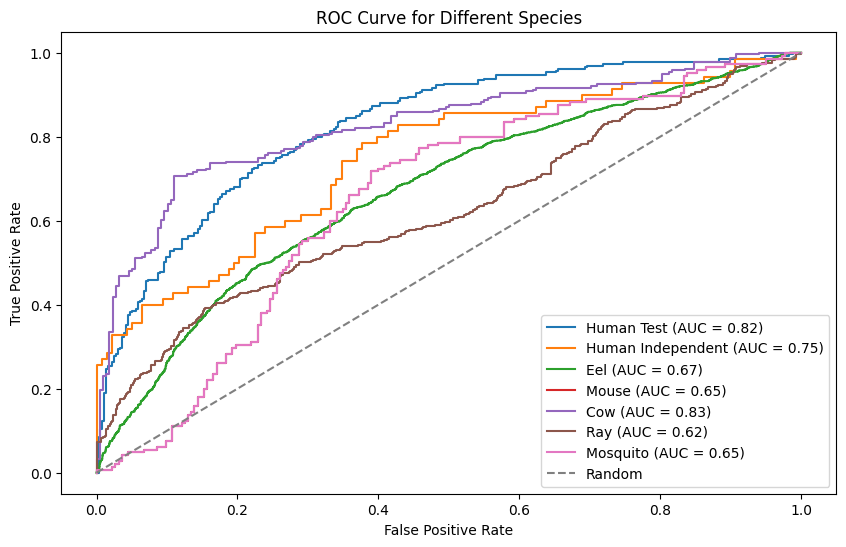

Evaluation for Human Test dataset:
Accuracy: 0.7451
Precision: 0.6807
Recall: 0.7490
F1 Score: 0.7132
MCC: 0.4866
Cohen's Kappa: 0.4848


Evaluation for Human Independent dataset:
Accuracy: 0.6538
Precision: 0.4914
Recall: 0.8143
F1 Score: 0.6129
MCC: 0.3680
Cohen's Kappa: 0.3329


Evaluation for Eel dataset:
Accuracy: 0.6360
Precision: 0.5203
Recall: 0.5964
F1 Score: 0.5558
MCC: 0.2516
Cohen's Kappa: 0.2499


Evaluation for Mouse dataset:
Accuracy: 0.5788
Precision: 0.4793
Recall: 0.8000
F1 Score: 0.5995
MCC: 0.2420
Cohen's Kappa: 0.2104


Evaluation for Cow dataset:
Accuracy: 0.7440
Precision: 0.7328
Recall: 0.8033
F1 Score: 0.7665
MCC: 0.4870
Cohen's Kappa: 0.4845


Evaluation for Ray dataset:
Accuracy: 0.5427
Precision: 0.5273
Recall: 0.6186
F1 Score: 0.5693
MCC: 0.0897
Cohen's Kappa: 0.0884


Evaluation for Mosquito dataset:
Accuracy: 0.5788
Precision: 0.4793
Recall: 0.8000
F1 Score: 0.5995
MCC: 0.2420
Cohen's Kappa: 0.2104




In [ ]:
import deepchem as dc
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score

datasets = {
    'Human Test': test_dataset,
    'Human Independent': dataset_humanIndependent,
    'Eel': dataset_eel,
    'Mouse': dataset_mouse,
    'Cow': dataset_cow,
    'Ray': dataset_ray,
    'Mosquito': dataset_mosquito
}

# Set up the plot
plt.figure(figsize=(10, 6))

evaluation_metrics = {}

# Evaluate and plot ROC curve for each dataset
for species, data in datasets.items():
    X = data.X
    y_true = data.y.ravel()

    # Make predictions on the test dataset
    y_pred = best_model.predict(data).reshape(-1, 2)

    y_pred_positive = y_pred[:, 1]

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_positive)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Calculate the confusion matrix
    y_pred_binary = np.argmax(y_pred, axis=1)  # Convert probabilities to binary predictions
    conf_matrix = confusion_matrix(y_true, y_pred_binary)

    # Calculate other evaluation metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    cohen_kappa = cohen_kappa_score(y_true, y_pred_binary)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa
    }

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(conf_matrix)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics.to_excel('evaluation_metrics_GAT.xlsx', index_label='Species')



##References

* https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Graph_Convolutions.ipynb
* Ramsundar, B., Eastman, P., Walters, P., Pande, V., Leswing, K., & Wu, Z. (2019). Deep Learning for the Life Sciences. O’Reilly Media. https://www.amazon.com/Deep-Learning-Life-Sciences-Microscopy/dp/1492039837
* Vignaux, P. A., Lane, T. R., Urbina, F., Gerlach, J., Puhl, A. C., Snyder, S. H., & Ekins, S. (2023). Validation of Acetylcholinesterase Inhibition Machine Learning Models for Multiple Species. Chemical Research in Toxicology, 36(2), 188–201. https://doi.org/10.1021/acs.chemrestox.2c00283
* Duvenaud, D., Maclaurin, D., Aguilera-Iparraguirre, J., Gómez-Bombarelli, R., Hirzel, T., Aspuru-Guzik, A., & Adams, R. P. (2015). Convolutional Networks on Graphs for Learning Molecular Fingerprints (arXiv:1509.09292). arXiv. http://arxiv.org/abs/1509.09292
* Veličković, P., Cucurull, G., Casanova, A., Romero, A., Lio, P., & Bengio, Y. (2017). Graph attention networks. arXiv preprint arXiv:1710.10903.
